This notebook highlights chapter 7 of Wes Gray's *Quantitative Value*.
This notebook relies on two large data files:

1. Firm-level market data (e.g., stock prices and share counts) from the [Center for Research in Security Prices (CRSP)](https://www.crsp.org/) in `crsp.csv` 
1. Firm-level fundamentals (i.e., financial statement information) from [Compustat](https://www.marketplace.spglobal.com/en/datasets/compustat-fundamentals-(8)) in `compustat.csv`

This notebook walks you through the steps to test a few of the quantitative value strategies in chapter 7 of Gray:

1. Earnings yield ($E/M$)
1. Book-to-market equity ratio ($B/M$)

We will focus on code and results in this notebook.
Please see chapters 1 and 7 of Gray for a summary of the underlying finance concepts. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
plt.rcParams['figure.dpi'] = 150
np.set_printoptions(precision=4, suppress=True)
pd.options.display.float_format = '{:.4f}'.format

In [3]:
import pandas_datareader as pdr
import requests_cache
session = requests_cache.CachedSession()

# Import the data from CRSP and Compustat

## CRSP

The CRSP data provide the following variables:

1. `PERMNO` is the stock identifier
1. `date` is the last trading day of the month
1. `SHRCD` indicates share class, and we can ignore it
1. `PRC` is the share price in dollars, and negative prices indicate the price is the midpoint of the bid-ask spread instead of a transaction
1. `SHROUT` is the number of shares outstanding in thousands

Read the CRSP data into a data frame named `crsp`.
Be sure to parse dates.
The codea `A`, `B`, and `C` indicate missing values.

In [4]:
crsp = pd.read_csv('../../Data/crsp.csv', parse_dates=['date'], na_values=list('ABC'))

## Compustat

The Compustat data provide the following variables:

1. `GVKEY` is the S&P firm identifier
1. `LPERMNO` is the link between CRSP and Compustat
1. `datadate` is the date of the filing, which is the last day of the fiscal year
1. `fyear` is the fiscal year
1. `ceq` is the book value of equity
1. `ib` is income before extraordinary items

Read the Compustat data into a data frame named `compustat`.
Be sure to parse dates.

In [5]:
compustat = pd.read_csv('../../Data/compustat.csv', parse_dates=['datadate'])

In [6]:
compustat['datadate'].dt.month.value_counts()

12    202688
6      23350
9      19574
3      16431
10     11069
1      10765
8       6675
7       6137
5       6026
4       5799
11      5661
2       4787
Name: datadate, dtype: int64

# Create interim data frames

To test the earnings yield and book/market investment strategies, we need to match the following data:

1. Fundamentals from December of year $t-1$
1. Market capitalizations from June of year $t$
1. 12-month returns from July of year $t$ through June of year $t+1$

The simplest and clearest way to match these data is to create one data frame for each of these three data sets.

## Fundamentals from December of year $t-1$

We will use Compustat values as of December.
Create a new data frame named `compustat_dec` that contains only December values of `ceq` and `ib` plus `LPERMNO` and `datadate`.
Because some firms have fiscal years that do not end in December, use `.groupby()`, `pd.Grouper()` with `A-DEC`, and `.last()` to roll forward earlier fiscal year ends.
Drop any rows with missing data, and use `.reset_index()` so that `LPERMNO` and `datadate` are variables we can modify and merge on.

In [7]:
compustat_dec = compustat.groupby(['LPERMNO', pd.Grouper(key='datadate', freq='A-DEC')])[['ceq', 'ib']].last()

In [8]:
compustat_dec.reset_index(inplace=True)

## Market capitalizations from June of year $t$

Calculate market capitalization and save it as a new variable named `ME`.
Then create a new data frame named `crsp_me` that contains only June values of `ME` plus `PERMNO` and `date`.
Drop any rows with missing data.

In [9]:
crsp_me = crsp.loc[crsp['date'].dt.month == 6].dropna()

In [10]:
crsp_me['ME'] = crsp_me['PRC'].abs() * crsp_me['SHROUT'] / 1000

In [11]:
crsp_me = crsp_me[['PERMNO', 'date', 'ME']].copy()

In [12]:
crsp_me.reset_index(inplace=True)

## Returns from July of year $t$ to June of year $t+1$

Calculate the July through June returns for each `PERMNO`, and save them as a new data frame named `crsp_ret`.
I suggest you:

1. Use the sum of log returns to speed up your calculations
1. Use `.groupby` and `pd.Grouper` (with `A-JUN`) to calculate 12-month returns
1. Drop 12-month returns that use fewer than 12 months of monthly returns
1. Use `.reset_index()` to keep `PERMNO` and `date` as columns

In [13]:
crsp['log1pRET'] = np.log1p(crsp['RET'])

In [14]:
crsp_ret = crsp.groupby(['PERMNO', pd.Grouper(key='date', freq='A-JUN')])['log1pRET'].agg(['sum', 'size'])

In [15]:
crsp_ret['RET12'] = np.exp(crsp_ret['sum']) - 1

In [16]:
crsp_ret = crsp_ret[['RET12']].copy()

In [17]:
crsp_ret.reset_index(inplace=True)

# Combine these three data frames as described above

Combine these three data frames as described above.
I find it easiest to add 6 months to Compustat dates and subtract 12 months from the CRSP returns dates so that dates are portfolio formation dates.
Note that CRSP market capitalization dates are the last business day of June, so we also need to move those to the last calendar day in June.

In [18]:
crsp_ret['datem12'] = crsp_ret['date'] - pd.offsets.MonthEnd(12)

In [19]:
crsp_ret.head(2)

,PERMNO,date,RET12,datem12
0,10000,1986-06-30,-0.2929,1985-06-30
1,10000,1987-06-30,-0.9293,1986-06-30


In [20]:
crsp_me['datep0'] = crsp_me['date'] + pd.offsets.MonthEnd(0)

In [21]:
crsp_me.head(2)

,index,PERMNO,date,ME,datep0
0,5,10000,1986-06-30,11.7346,1986-06-30
1,23,10001,1986-06-30,6.0331,1986-06-30


In [22]:
compustat_dec['datadatep6'] = compustat_dec['datadate'] + pd.offsets.MonthEnd(6)

In [23]:
compustat_dec.head(2)

,LPERMNO,datadate,ceq,ib,datadatep6
0,10000,1986-12-31,0.4180,-0.7300,1987-06-30
1,10001,1986-12-31,5.4320,0.6690,1987-06-30


In [24]:
_ = crsp_ret.merge(crsp_me, left_on=['PERMNO', 'datem12'], right_on=['PERMNO', 'datep0'], suffixes=['_ret', '_me'])

In [25]:
_.head(2)

,PERMNO,date_ret,RET12,datem12,index,date_me,ME,datep0
0,10000,1987-06-30,-0.9293,1986-06-30,5,1986-06-30,11.7346,1986-06-30
1,10001,1987-06-30,0.0239,1986-06-30,23,1986-06-30,6.0331,1986-06-30


In [26]:
df = _.merge(compustat_dec, left_on=['PERMNO', 'datep0'], right_on=['LPERMNO', 'datadatep6'])

In [27]:
del _

In [28]:
df

,PERMNO,date_ret,RET12,datem12,index,date_me,ME,datep0,LPERMNO,datadate,ceq,ib,datadatep6
0,10001,1988-06-30,0.1405,1987-06-30,35,1987-06-30,5.8221,1987-06-30,10001,1986-12-31,5.4320,0.6690,1987-06-30
1,10001,1989-06-30,0.1998,1988-06-30,47,1988-06-30,6.2000,1988-06-30,10001,1987-12-31,5.3690,0.3120,1988-06-30
2,10001,1990-06-30,0.4684,1989-06-30,59,1989-06-30,7.0070,1989-06-30,10001,1988-12-31,5.5120,0.5420,1989-06-30
3,10001,1991-06-30,0.1400,1990-06-30,71,1990-06-29,10.0523,1990-06-30,10001,1989-12-31,6.3210,1.2080,1990-06-30
4,10001,1992-06-30,0.1755,1991-06-30,83,1991-06-28,11.2665,1991-06-30,10001,1990-12-31,7.1790,1.1310,1991-06-30
...,...,...,...,...,...,...,...,...,...,...,...,...,...
244787,93436,2018-06-30,-0.0516,2017-06-30,3739872,2017-06-30,60339.3278,2017-06-30,93436,2016-12-31,4752.9110,-674.9140,2017-06-30
244788,93436,2019-06-30,-0.3484,2018-06-30,3739884,2018-06-29,58478.4639,2018-06-30,93436,2017-12-31,4237.2420,-1961.4000,2018-06-30
244789,93436,2020-06-30,3.8322,2019-06-30,3739896,2019-06-28,40025.7101,2019-06-30,93436,2018-12-31,4923.2430,-976.0910,2019-06-30
244790,93436,2021-06-30,2.1473,2020-06-30,3739908,2020-06-30,200844.6712,2020-06-30,93436,2019-12-31,6618.0000,-862.0000,2020-06-30


# Calculate price ratios

Gray provides complex definitions of $E/M$ and $B/M$.
However, we will get similar results with simpler definitions.

1. $E/M = \frac{ib}{ME}$
1. $B/M = \frac{ceq}{ME}$

I will call these variables `E_M` and `B_M`, respectively.
Note that negative values of $E/M$ and $B/M$ are not meaninfgul, so we can replace them with `np.nan`.

In [29]:
df.eval('E_M = ib / ME', inplace=True) # same as: df['E_M'] = df['ib'] / df[/ME]
df.eval('B_M = ceq / ME', inplace=True)

In [30]:
df['E_M'] = np.where(df['E_M'] > 0, df['E_M'], np.nan)
df['B_M'] = np.where(df['B_M'] > 0, df['B_M'], np.nan)

# Form deciles each year on price ratios

Finally, we can use the following to form decile portfolios on $E/M$ and $B/M$ each year:

1. `.groupby()`
1. `.transform()`
1. `pd.qcut()`

I will call these decile portfolios `E_M_10` and `B_M_10`, respectively.
Because `E_M` and `B_M` are sparse in the early years of the data, I will start my analysis from 1965.

In [31]:
1 + pd.qcut(x=np.arange(10), q=5, labels=False)

array([1, 1, 2, 2, 3, 3, 4, 4, 5, 5])

In [32]:
df.query('datep0 > "1965"', inplace=True)

In [33]:
df['E_M_10'] = df.groupby('datep0')['E_M'].transform(lambda x: 1 + pd.qcut(x=x, q=10, labels=False))
df['B_M_10'] = df.groupby('datep0')['B_M'].transform(lambda x: 1 + pd.qcut(x=x, q=10, labels=False))

# How do these portfolios perform?

In [34]:
df_2_ew = df.groupby(['datep0', 'B_M_10'])['RET12'].mean().to_frame('EW')

In [35]:
df_2_vw = df.groupby(['datep0', 'B_M_10']).apply(lambda x: np.average(a=x['RET12'], weights=x['ME'])).to_frame('VW')

In [36]:
df_2 = df_2_ew.join(df_2_vw).unstack()

In [37]:
df_2.index.name = 'Date'

In [38]:
['EW', 'VW']

['EW', 'VW']

In [39]:
['DEC ' + str(i) for i in range(1, 11)]

['DEC 1',
 'DEC 2',
 'DEC 3',
 'DEC 4',
 'DEC 5',
 'DEC 6',
 'DEC 7',
 'DEC 8',
 'DEC 9',
 'DEC 10']

In [40]:
 pd.MultiIndex.from_product([['EW', 'VW'], ['DEC ' + str(i) for i in range(1, 11)]])

MultiIndex([('EW',  'DEC 1'),
            ('EW',  'DEC 2'),
            ('EW',  'DEC 3'),
            ('EW',  'DEC 4'),
            ('EW',  'DEC 5'),
            ('EW',  'DEC 6'),
            ('EW',  'DEC 7'),
            ('EW',  'DEC 8'),
            ('EW',  'DEC 9'),
            ('EW', 'DEC 10'),
            ('VW',  'DEC 1'),
            ('VW',  'DEC 2'),
            ('VW',  'DEC 3'),
            ('VW',  'DEC 4'),
            ('VW',  'DEC 5'),
            ('VW',  'DEC 6'),
            ('VW',  'DEC 7'),
            ('VW',  'DEC 8'),
            ('VW',  'DEC 9'),
            ('VW', 'DEC 10')],
           )

In [41]:
df_2.columns = pd.MultiIndex.from_product([['EW', 'VW'], ['DEC ' + str(i) for i in range(1, 11)]])

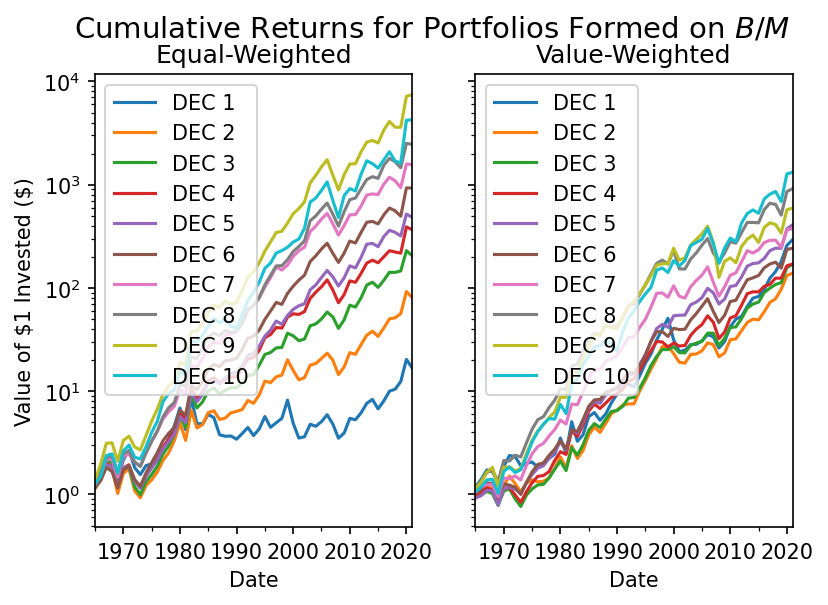

In [42]:
fig, ax = plt.subplots(1, 2, sharey=True)
df_2['EW'].add(1).cumprod().plot(ax=ax[0], title='Equal-Weighted', logy=True)
df_2['VW'].add(1).cumprod().plot(ax=ax[1], title='Value-Weighted', logy=True)
ax[0].set_ylabel('Value of \$1 Invested (\$)')
plt.suptitle('Cumulative Returns for Portfolios Formed on $B/M$', fontsize=14)
plt.show()

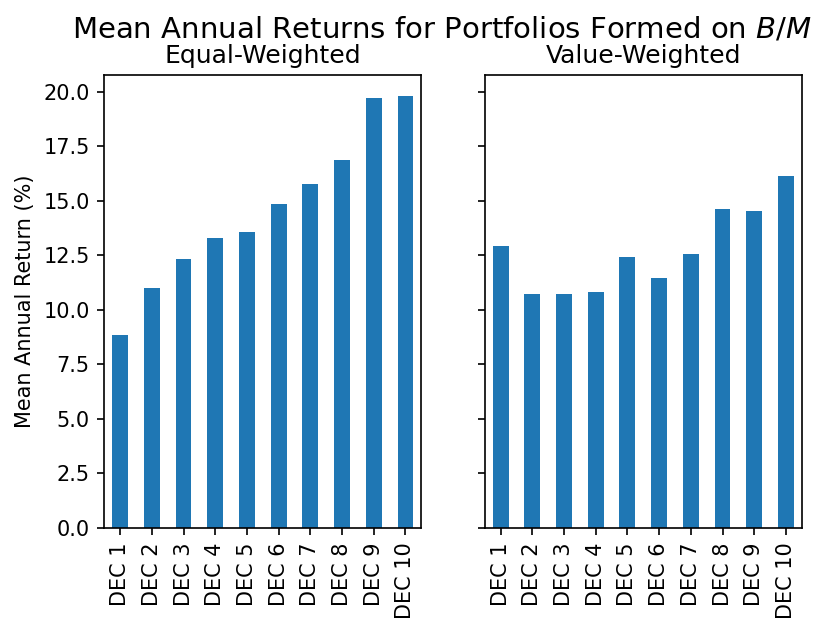

In [43]:
fig, ax = plt.subplots(1, 2, sharey=True)
df_2['EW'].mean().mul(100).plot(kind='bar', ax=ax[0], title='Equal-Weighted')
df_2['VW'].mean().mul(100).plot(kind='bar', ax=ax[1], title='Value-Weighted')
ax[0].set_ylabel('Mean Annual Return (%)')
plt.suptitle('Mean Annual Returns for Portfolios Formed on $B/M$', fontsize=14)
plt.show()